In [1]:
import csv
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, f1_score, auc, log_loss

from keras import models
from keras import layers

import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


# Import the Data

In [2]:
raw_1 = pd.read_csv('28spk_clean_data.csv')
raw_2 = pd.read_csv('56spk_clean_data.csv')

In [3]:
raw_train = raw_1[:]
raw_test = raw_2[:]

In [4]:
train_list = raw_train.iloc[:, -1]
train_encoder = LabelEncoder()
train_y = train_encoder.fit_transform(train_list)

In [5]:
train_scaler = StandardScaler()
train_X = train_scaler.fit_transform(np.array(raw_train.iloc[:, :-1], dtype = float))

In [6]:
test_list = raw_test.iloc[:, -1]
test_encoder = LabelEncoder()
test_y = test_encoder.fit_transform(test_list)

In [7]:
test_scaler = StandardScaler()
test_X = test_scaler.fit_transform(np.array(raw_test.iloc[:, :-1], dtype = float))

# Logistic and Random Forest Classification

In [8]:
'''

Fitting Logistic Regression Model

'''

# for i in [0.01, 0.05, 0.25, 0.5, 1]:
lr = LogisticRegression(C=0.1)
lr.fit(train_X, train_y)
lr_pred = lr.predict(test_X)
lr_probs = lr.predict_proba(test_X)

print("Accuracy: ", accuracy_score(test_y, lr_pred))
print("Confusion Matrix: ",(confusion_matrix(test_y, lr_pred)))
print("Report: ",(classification_report(test_y, lr_pred)))

Accuracy:  0.9973997833152762
Confusion Matrix:  [[23008    67]
 [   53 23022]]
Report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00     23075
           1       1.00      1.00      1.00     23075

    accuracy                           1.00     46150
   macro avg       1.00      1.00      1.00     46150
weighted avg       1.00      1.00      1.00     46150



In [9]:
'''

Calculate Log-Loss

'''

print(log_loss(test_y, lr_probs, normalize=False))
print(log_loss(test_y, lr_probs))

608.3302538505379
0.013181587299036575


In [10]:
'''

Fitting Random Forest Classifier

'''

rf = RandomForestClassifier()
rf.fit(train_X, train_y)

rf_pred = rf.predict(test_X)

print("Accuracy: ", accuracy_score(test_y, rf_pred))

Accuracy:  1.0


No Skill: ROC AUC=0.500
Logistic: ROC AUC=1.000
Random Forest: ROC AUC=1.000


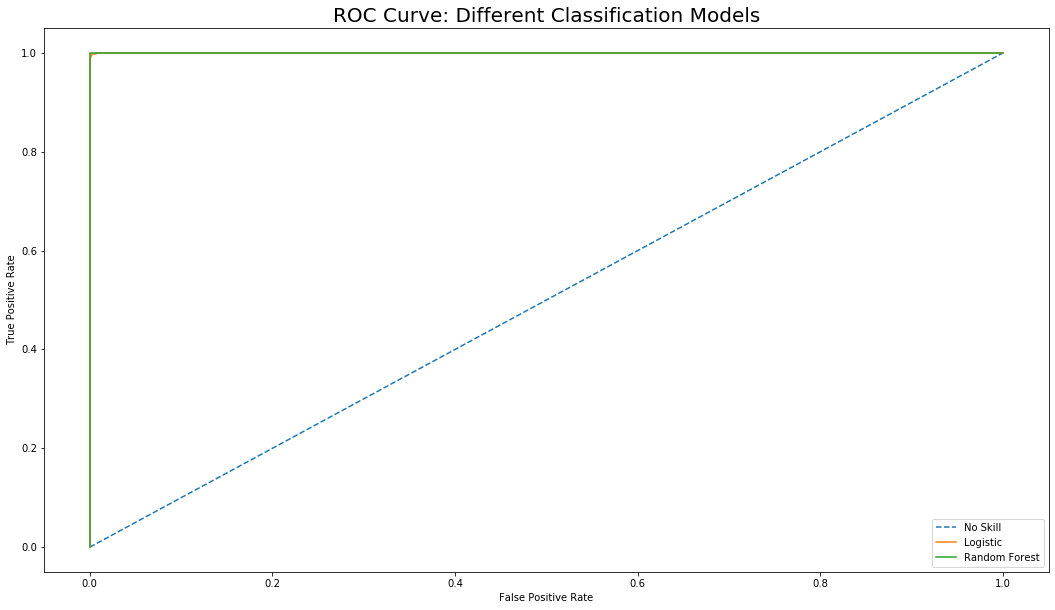

In [11]:
'''

Plot ROC curve after fitting a model

'''

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(test_y))]

# Predict Probabilities
lr_probs = lr.predict_proba(test_X)
rf_probs = rf.predict_proba(test_X)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
rf_probs = rf_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(test_y, ns_probs)
lr_auc = roc_auc_score(test_y, lr_probs)
rf_auc = roc_auc_score(test_y, rf_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
print('Random Forest: ROC AUC=%.3f' % (rf_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test_y, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_y, lr_probs)
rf_fpr, rf_tpr, _ = roc_curve(test_y, rf_probs)

# plot the roc curve for the model
f1,ax1 = plt.subplots(figsize =(18,10))
ax1.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
ax1.plot(lr_fpr, lr_tpr, label='Logistic')
ax1.plot(rf_fpr, rf_tpr, label='Random Forest')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.title('ROC Curve: Different Classification Models', fontsize=20)
# plt.savefig('ROC_classification_models.png')
plt.show();

Logistic: f1=0.997 auc=1.000
Random Forest: f1=1.000 auc=1.000


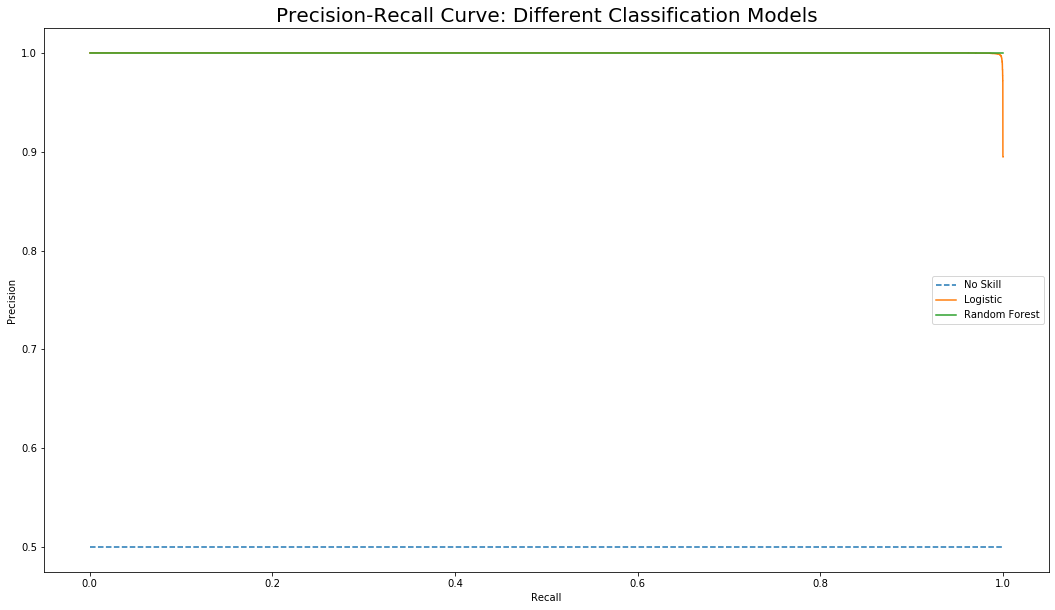

In [12]:
'''

Plot Precision-Recall curve after fitting a model

'''

# predict class values

lr_precision, lr_recall, _ = precision_recall_curve(test_y, lr_probs)
lr_f1, lr_auc = f1_score(test_y, lr_pred), auc(lr_recall, lr_precision)

rf_precision, rf_recall, _ = precision_recall_curve(test_y, rf_probs)
rf_f1, rf_auc = f1_score(test_y, rf_pred), auc(rf_recall, rf_precision)

# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
print('Random Forest: f1=%.3f auc=%.3f' % (rf_f1, rf_auc))

# plot the precision-recall curves
no_skill = len(test_y[test_y==1]) / len(test_y)

f2,ax2 = plt.subplots(figsize =(18,10))
ax2.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
ax2.plot(lr_recall, lr_precision, label='Logistic')
ax2.plot(rf_recall, rf_precision, label='Random Forest')


# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend()
plt.title('Precision-Recall Curve: Different Classification Models', fontsize=20)
# plt.savefig('precision_recall_classification_models.png')
plt.show();

# NN Model

In [14]:
X_train, X_validation, y_train, y_validation = train_test_split(train_X, train_y, test_size=0.2)

In [15]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))

model.add(layers.Dense(128, activation='relu'))

# model.add(layers.Dense(32, activation='relu'))

# model.add(layers.Dense(16, activation='sigmoid'))

model.add(layers.Dense(2, activation='softmax'))

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               7168      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 40,322
Trainable params: 40,322
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=128,
                    validation_data=(X_validation, y_validation)
                   )

Train on 18515 samples, validate on 4629 samples
Epoch 1/20
18515/18515 [==============================] - 1s 30us/step - loss: 0.0597 - accuracy: 0.9778 - val_loss: 0.0074 - val_accuracy: 0.9972
Epoch 2/20
18515/18515 [==============================] - 0s 24us/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 0.0036 - val_accuracy: 0.9989
Epoch 3/20
18515/18515 [==============================] - 0s 19us/step - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.0017 - val_accuracy: 0.9996
Epoch 4/20
18515/18515 [==============================] - 0s 16us/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.0013 - val_accuracy: 0.9998
Epoch 5/20
18515/18515 [==============================] - 0s 18us/step - loss: 4.3233e-04 - accuracy: 0.9999 - val_loss: 0.0016 - val_accuracy: 0.9996
Epoch 6/20
18515/18515 [==============================] - 0s 22us/step - loss: 5.8591e-04 - accuracy: 0.9999 - val_loss: 0.0010 - val_accuracy: 0.9996
Epoch 7/20
18515/18515 [==============================] - 0s 

Text(0, 0.5, 'Loss')

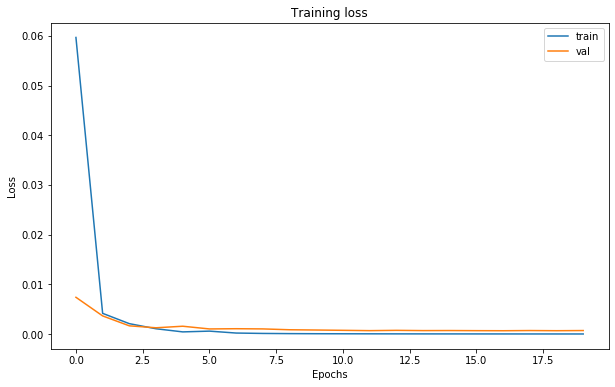

In [19]:
plt.figure(figsize=(10,6))
plt.title("Training loss")
plt.plot( history.history["loss"] )
plt.plot( history.history["val_loss"] )
plt.legend(['train', 'val'], loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

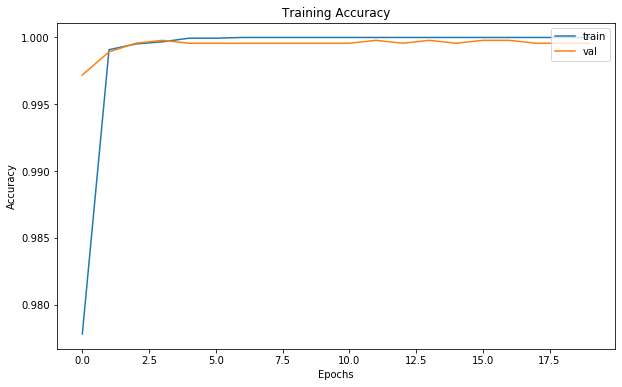

In [20]:
plt.figure(figsize=(10,6))
plt.title("Training Accuracy")
plt.plot( history.history["accuracy"] )
plt.plot( history.history["val_accuracy"] )
plt.legend(['train', 'val'], loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [21]:
test_loss, test_acc = model.evaluate(test_X,test_y)

46150/46150 [==============================] - 1s 17us/step


In [22]:
print('test_acc: ',test_acc)
print('test_loss: ',test_loss)

test_acc:  0.998938262462616
test_loss:  0.003386285053844838


In [23]:
### THIS FILE ENDS HERE ###